# Domino classification with a CNN
This project is about classifying domino tiles. I have taken 100 photos of all different versions of dominos from 0 to 6 - and resized the photos to 100x100px. The idea was to classify each of the 28 versions of domino tiles. 
 

In [1]:
import numpy as np
import os # Working with files and folders
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image # Image processing
from PIL import ImageEnhance # Image processing
from PIL import ImageFilter
from PIL import ImageOps  
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [2]:
rootdir = os.getcwd()

In [3]:
print(rootdir)

/Users/Christoffer/Dropbox/Projekt/Machine Learning/Mina projekt/domino


In [4]:
image_dir = rootdir + '/data'
example_folder = '/3x3/'
example_image = '20180505_181945.jpg'

## Image processing functions

In [5]:
def crop_image(im, sq_size):
  new_width = sq_size
  new_height = sq_size
  width, height = im.size   # Get dimensions 
  left = (width - new_width)/2
  top = (height - new_height)/2
  right = (width + new_width)/2
  bottom = (height + new_height)/2
  imc = im.crop((left, top, right, bottom))
  return imc 

def rotated_images(im):
    im_list = [im]
    im_list.append(im.rotate(45))
    im_list.append(im.rotate(90))
    im_list.append(im.rotate(135))    
    im_list.append(im.rotate(180))
    im_list.append(im.rotate(225))    
    im_list.append(im.rotate(270))
    im_list.append(im.rotate(315))    
    return im_list

def invert_images(im_list):
    inverted_im_list = []
    for im in im_list:
        inverted_im_list.append(im)
        inverted_im_list.append(ImageOps.invert(im))
    return inverted_im_list

def improve_contrast(im):
    im = im.convert('L') # Turns black/white
    im = im.filter(ImageFilter.CONTOUR)
    c_enhancer = ImageEnhance.Contrast(im)
    b_enhancer = ImageEnhance.Brightness(im)
    im = c_enhancer.enhance(5)
    im = b_enhancer.enhance(1.2)    
    return im


### Sample image

Image size: (100, 100)


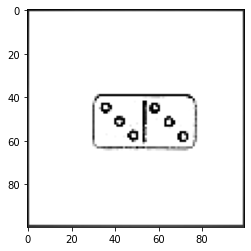

In [6]:

im = Image.open(os.path.join(image_dir + example_folder, example_image))
print("Image size:", im.size)
#im = im.rotate(45)
im = improve_contrast(im)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)

In [7]:
#im = Image.open(os.path.join(image_dir + "/3x3/", example_image))
#plt.imshow(im)
#rotated_image_list = rotated_images(im)
#rotandinv_list = invert_images(rotated_image_list)
#print("Augmented images: ", len(rotandinv_list))
#for r_im in rotandinv_list:
#    plt.imshow(r_im)
#    plt.show()

## Augment data

In [8]:
X = []
y = []
im_squared_size = 80

for subdir, dirs, files in os.walk(image_dir):
    dir_name = subdir.split("/")[-1] 
    if dir_name and len(dir_name) == 3 and "x" in dir_name:
        #print(":", dir_name)
        for filename in files:            
            im = Image.open(os.path.join(image_dir + "/" + dir_name + "/", filename))
            if im.size == (100,100):
                #print(dir_name)
                im = improve_contrast(im)
                im = crop_image(im, im_squared_size)
                rotated_images_list = rotated_images(im) # Create extra data with 3 rotated images of every image
                rotated_inverted_list = invert_images(rotated_images_list)
                for aug_image in rotated_inverted_list:
                    y.append(dir_name)
                    im_arr = np.array(aug_image)
                    X.append(im_arr)
                

# Turn to numpy arrays            
X = np.array(X)
y_string_keys = np.array(y)                

In [9]:

X = X.astype("float32") / 255 # Pixel value needs to be between 0 and 1
X = np.expand_dims(X, -1) 
print("Data size: ", X.shape[0])

Data size:  44736


In [10]:
num_classes = len(np.unique(y_string_keys))
print("Num classes: ", num_classes)

Num classes:  28


In [11]:
# Transfer target key from string (e.g. '2x1') to number (index in labels_list)
y_as_numbers = []
labels = dict(enumerate(np.unique(y_string_keys).flatten(), 0))
print("Labels", labels)
val_list = list(labels.values())
for i,val in enumerate(y_string_keys):
    y_as_numbers.append(int(val_list.index(val)))

Labels {0: '0x0', 1: '1x0', 2: '1x1', 3: '2x0', 4: '2x1', 5: '2x2', 6: '3x0', 7: '3x1', 8: '3x2', 9: '3x3', 10: '4x0', 11: '4x1', 12: '4x2', 13: '4x3', 14: '4x4', 15: '5x0', 16: '5x1', 17: '5x2', 18: '5x3', 19: '5x4', 20: '5x5', 21: '6x0', 22: '6x1', 23: '6x2', 24: '6x3', 25: '6x4', 26: '6x5', 27: '6x6'}


In [12]:
# Transfer target key from number to one hot encoded array
y = to_categorical(y_as_numbers, num_classes)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train images: ", X_train.shape)
print("Test images: ", X_test.shape[0])

Train images:  (35788, 80, 80, 1)
Test images:  8948


### Test samples from augmented data

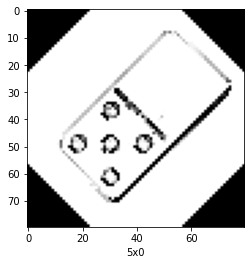

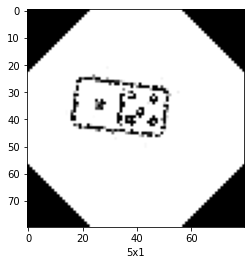

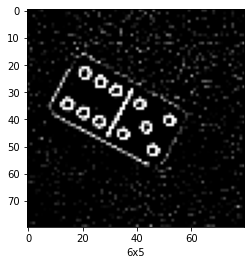

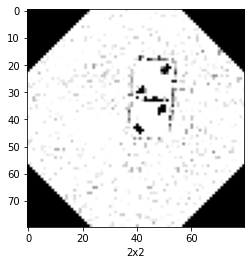

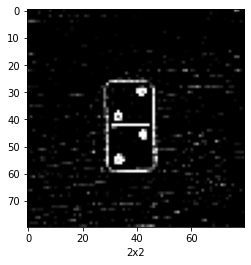

In [14]:
# Look at test samples
samples = np.random.choice(len(X_test), 5)
for i, prediction in enumerate(samples):    
    #print(np.argmax(prediction), labels[np.argmax(prediction)])
    X_test[samples[i]]
    plt.imshow(X_test[samples[i]], cmap='gray')
    plt.xlabel(labels[np.argmax(y_test[samples[i]])])
    plt.show()

## Model

In [15]:
input_shape = (im_squared_size,im_squared_size,1)

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)         

2021-11-04 21:19:28.955188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-04 21:19:28.955288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
es = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
model.fit(X_train, y_train, validation_split=0.1, epochs=20, callbacks=[es])


2021-11-04 21:19:29.266766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 21:19:29.267747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-04 21:19:29.460733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
1007/1007 [==============================] - ETA: 0s - loss: 2.3794 - accuracy: 0.2065

2021-11-04 21:19:52.802559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1007/1007 [==============================] - 25s 24ms/step - loss: 2.3794 - accuracy: 0.2065 - val_loss: 1.6905 - val_accuracy: 0.3990
Epoch 2/20
1007/1007 [==============================] - 26s 26ms/step - loss: 1.1573 - accuracy: 0.5940 - val_loss: 0.6938 - val_accuracy: 0.7530
Epoch 3/20
1007/1007 [==============================] - 27s 27ms/step - loss: 0.5324 - accuracy: 0.8208 - val_loss: 0.2514 - val_accuracy: 0.9226
Epoch 4/20
1007/1007 [==============================] - 27s 26ms/step - loss: 0.2762 - accuracy: 0.9097 - val_loss: 0.1285 - val_accuracy: 0.9662
Epoch 5/20
1007/1007 [==============================] - 27s 27ms/step - loss: 0.1691 - accuracy: 0.9450 - val_loss: 0.0960 - val_accuracy: 0.9709
Epoch 6/20
1007/1007 [==============================] - 27s 26ms/step - loss: 0.1129 - accuracy: 0.9626 - val_loss: 0.0587 - val_accuracy: 0.9810
Epoch 7/20
1007/1007 [==============================] - 27s 26ms/step - loss: 0.0949 - accuracy: 0.9686 - val_loss: 0.0571 - val_accura

In [17]:
scores = model.evaluate(X_test, y_test)
print("Model accuracy: {:.2%}".format(scores[1]))
print("Baseline guess accuracy: {:.2%}".format(1/num_classes))
print("Better than guessing: {}x".format((scores[1] /(1/num_classes))))

280/280 [==============================] - 3s 12ms/step - loss: 0.0176 - accuracy: 0.9947
Model accuracy: 99.47%
Baseline guess accuracy: 3.57%
Better than guessing: 27.852927207946777x


## Analyze results

2021-11-04 21:28:29.594353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


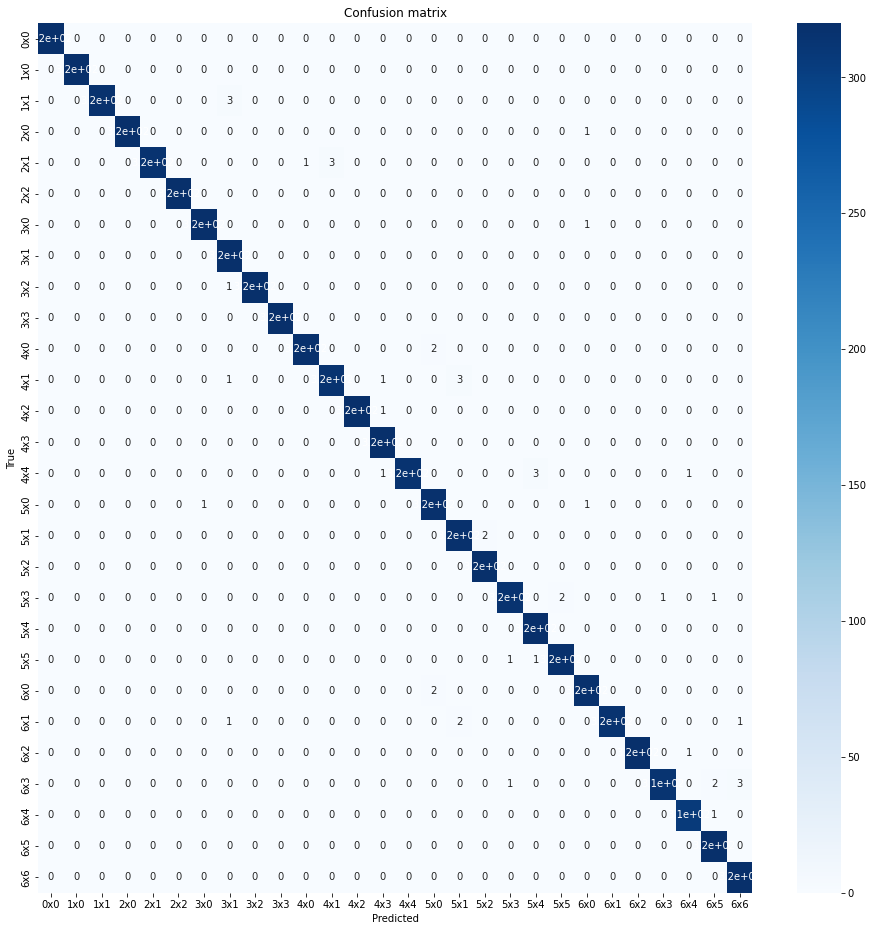

In [18]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = []
y_test_classes = []
for y in y_pred:
    y_pred_classes.append(labels[np.argmax(y)])
for y in y_test:
    y_test_classes.append(labels[np.argmax(y)])
cf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

fig = plt.figure(figsize=(16,16))
cfmap = sns.heatmap(cf_matrix, yticklabels=list(labels.values()), xticklabels=list(labels.values()), annot=True, cmap='Blues', )
cfmap.set(xlabel="Predicted", ylabel="True", title="Confusion matrix")
plt.show()

### Test predictions

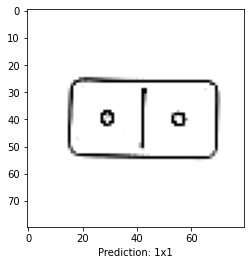

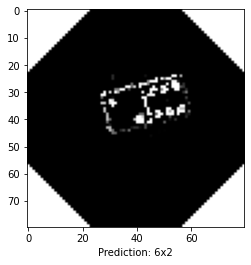

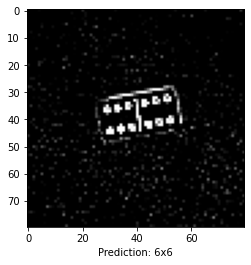

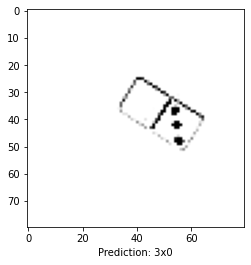

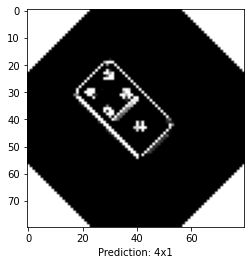

In [19]:

samples = np.random.choice(len(y_test), 5)
samples_to_predict = []
for sample in samples:
    samples_to_predict.append(X_test[sample])
    #print(y_test[sample])

predictions = model.predict(np.array(samples_to_predict))

for i, prediction in enumerate(predictions):    
    #print(np.argmax(prediction), labels[np.argmax(prediction)])
    plt.imshow(X_test[samples[i]], cmap='gray')
    plt.xlabel("Prediction: " + labels[np.argmax(prediction)])
    plt.show()

# Comments on results

The accuracy of the model is nearly 100%. The confusions are between tiles of similar amount of dots.

When I started off with the model I did not use a large enough network and only one Conv-layer which made the accuracy barely better than a random guess.

A few comments on alterations:
- Adding/removing inversion of images changed accuracy 4%-units (96 to ~100%).
- Adding 45-degree rotations of the images did not do much to accuracy


99.0 with 45 degree rotations.
98.0 without 45 degree (4 times less data)

Test (baseline 98%):
- Remove Conv2D/Maxpooling pairs
- Decrease nodes overall
- Remove all Maxpooling layers -> SLOOOOOW. LOTS more parameters (170M vs 300k).

